# Dependencies & Variables

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt

In [ ]:
dh1 = [5,1,32,34]		# What is the first dihedral in the trimer?
dh2 = [54,57,62,64]		# What is the second dihedral in the trimer?
hs_on_monomer = [6,24]  # WThese are the hydrogens the polymer will propagte from
itp_file_path = '3mer_n.itp'
itp_file_path_1mer = '1mer_n.itp'
n = 21

# Extend Mol.itp

### Parse Mol.itp & Identify 'nmer'

In [ ]:
def parse_itp_file(file_path):
    data = {}
    current_section = None
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(';') or not line:
                continue
            elif line.startswith('[') and line.endswith(']'):
                current_section = line[1:-1].strip()
                data[current_section] = []
                if current_section in ['angles', 'moleculetype', 'atoms']:
                    next(file)  # Skip one line for certain sections
            else:
                line_data = line.split(';')[0].strip()
                if line_data:
                    if current_section == 'dihedrals':
                        if 'IMPROPER DIHEDRAL' in line_data:
                            next(file)  # Skip the next line for improper dihedrals
                            continue
                        elif 'PROPER DIHEDRAL' in line_data:
                            next(file)  # Skip the next line for proper dihedrals
                            continue
                    data[current_section].append(line_data.split())
    return data

def process_dihedrals_sections(file_path):
    improper_data = []
    proper_data = []
    with open(file_path, 'r') as file:
        section_flag = None  # Tracks the current section
        dihedrals_flag = False  # Flag to indicate dihedrals section
        section_type = None  # Tracks the type of dihedrals section
        for line in file:
            line = line.strip()
            if line.startswith('[ dihedrals ]'):
                dihedrals_flag = True
            elif dihedrals_flag and line.startswith('; IMPROPER DIHEDRAL ANGLES'):
                section_flag = 'improper'
                section_type = 'Improper Dihedrals'
            elif dihedrals_flag and line.startswith('; PROPER DIHEDRAL ANGLES'):
                section_flag = 'proper'
                section_type = 'Proper Dihedrals'
            elif '[ pairs ]' in line:
                break  # Stop collecting data after encountering [ pairs ]
            elif section_flag == 'improper' and line.strip() and not line.startswith(';'):
                improper_data.append(line.split())
            elif section_flag == 'proper' and line.strip() and not line.startswith(';'):
                proper_data.append(line.split())

    # Convert data to dataframes
    df_improper = pd.DataFrame(improper_data, columns=['ai', 'aj', 'ak', 'al', 'funct', 'c0', 'c1', 'c2'])
    df_proper = pd.DataFrame(proper_data, columns=['ai', 'aj', 'ak', 'al', 'funct', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5'])

    return df_improper, df_proper

def update_nmer_using_graph(df_atoms, df_bonds, dh1, dh2):
    """
    Updates the `nmer` column in `df_atoms` based on the trimer structure defined by dihedral centers (dh1, dh2).

    Args:
        df_atoms (DataFrame): DataFrame containing atom data with 'nr' as the atom identifier.
        df_bonds (DataFrame): DataFrame containing bond data with 'ai' and 'aj' as columns.
        dh1 (tuple): First dihedral center (edge defined by two atoms).
        dh2 (tuple): Second dihedral center (edge defined by two atoms).

    Returns:
        DataFrame: Updated df_atoms with the `nmer` column.
    """
    G = nx.Graph()

    # Add edges from bonds
    for _, row in df_bonds.iterrows():
        G.add_edge(int(row['ai']), int(row['aj']))

    # Dihedral centers as edges
    dihedral_centers = [(dh1[1], dh1[2]), (dh2[1], dh2[2])]

    # Check if both edges exist in the same connected component
    components = list(nx.connected_components(G))
    component_with_both_edges = None
    for component in components:
        if dihedral_centers[0][0] in component and dihedral_centers[0][1] in component and \
           dihedral_centers[1][0] in component and dihedral_centers[1][1] in component:
            component_with_both_edges = component
            break

    # Handle disconnected units
    if component_with_both_edges is None:
        print("Units in original trimer are disconnected")
        df_atoms['nmer'] = 0
        return df_atoms

    # Assign nmer = 99 for the component containing both dihedral centers
    atom_to_nmer = {atom: 99 for atom in component_with_both_edges}
    df_atoms['nmer'] = df_atoms['nr'].astype(int).map(atom_to_nmer).fillna(0).astype(int)

    # Cut the dihedral center edges
    G.remove_edge(*dihedral_centers[0])
    G.remove_edge(*dihedral_centers[1])

    # Recompute components
    components = list(nx.connected_components(G))

    # Assign nmers for the split components
    for component in components:
        if dh1[1] in component:
            label = 1
        elif dh1[2] in component and dh2[1] in component:
            label = 2
        elif dh2[2] in component:
            label = 3
        else:
            continue  # Skip components not part of the main structure

        for atom in component:
            atom_to_nmer[atom] = label

    # Update nmer in df_atoms
    df_atoms['nmer'] = df_atoms['nr'].astype(int).map(atom_to_nmer).fillna(0).astype(int)

    return df_atoms

# Example usage
parsed_data = parse_itp_file(itp_file_path)
df_improper, df_proper = process_dihedrals_sections(itp_file_path)

# Convert each section to a DataFrame
df_atomtypes = pd.DataFrame(parsed_data.get('atomtypes', []), columns=['type', 'type_name', 'mass', 'charge', 'element', 'sigma', 'epsilon'])
df_moleculetype = pd.DataFrame(parsed_data.get('moleculetype', []), columns=['name', 'nrexcl'])
df_atoms = pd.DataFrame(parsed_data.get('atoms', []), columns=['nr', 'type', 'resnr', 'residue', 'atom', 'cgnr', 'charge', 'mass'])
df_bonds = pd.DataFrame(parsed_data.get('bonds', []), columns=['ai', 'aj', 'funct', 'c0', 'c1'])
df_angles = pd.DataFrame(parsed_data.get('angles', []), columns=['ai', 'aj', 'ak', 'funct', 'c0', 'c1'])
df_pairs = pd.DataFrame(parsed_data.get('pairs', []), columns=['ai', 'aj', 'funct'])

df_atoms = update_nmer_using_graph(df_atoms, df_bonds, dh1, dh2)

# Print the DataFrames
print("DataFrame df_atomtypes:")
print(df_atomtypes)

print("\nDataFrame df_moleculetype:")
print(df_moleculetype)

print("\nDataFrame df_atoms:")
print(df_atoms)

print("\nDataFrame df_bonds:")
print(df_bonds)

print("\nDataFrame df_angles:")
print(df_angles)

print("\nDataFrame df_pairs:")
print(df_pairs)

print("\nDataFrame df_improper:")
print(df_improper)

print("\nDataFrame df_proper:")
print(df_proper)


DataFrame df_atomtypes:
        type type_name     mass charge element        sigma      epsilon
0   opls_866      C866  12.0110  0.000       A  3.55000E-01  2.92880E-01
1   opls_833      S833  32.0600  0.000       A  3.60000E-01  1.48532E+00
2   opls_870      H870   1.0080  0.000       A  2.50000E-01  1.25520E-01
3   opls_873      S873  32.0600  0.000       A  3.60000E-01  1.48532E+00
4   opls_828      H828   1.0080  0.000       A  2.50000E-01  1.25520E-01
..       ...       ...      ...    ...     ...          ...          ...
89  opls_880      H880   1.0080  0.000       A  2.42000E-01  1.25520E-01
90  opls_859      H859   1.0080  0.000       A  2.50000E-01  1.25520E-01
91  opls_842      C842  12.0110  0.000       A  3.55000E-01  2.92880E-01
92  opls_892      C892   12.011      0       A     3.50E-01     2.76E-01
93  opls_893      H893    1.008      0       A     2.50E-01     1.26E-01

[94 rows x 7 columns]

DataFrame df_moleculetype:
  name nrexcl
0  UNK      3

DataFrame df_atoms:


In [ ]:
def assign_nmer_columns(df_atoms, df_bonds, df_angles, df_improper, df_proper):
    # Ensure the columns in df_atoms are integers
    df_atoms['nr'] = df_atoms['nr'].astype(int)
    df_atoms['nmer'] = df_atoms['nmer'].astype(int)

    # Create a mapping of atom number to nmer value
    atom_to_nmer = df_atoms.set_index('nr')['nmer'].to_dict()

    # Ensure the columns in other DataFrames are integers
    df_bonds[['ai', 'aj']] = df_bonds[['ai', 'aj']].astype(int)
    df_angles[['ai', 'aj', 'ak']] = df_angles[['ai', 'aj', 'ak']].astype(int)
    df_improper[['ai', 'aj', 'ak', 'al']] = df_improper[['ai', 'aj', 'ak', 'al']].astype(int)
    df_proper[['ai', 'aj', 'ak', 'al']] = df_proper[['ai', 'aj', 'ak', 'al']].astype(int)

    # Helper function to map nmer values to the respective columns
    def map_nmer(df, columns):
        for col in columns:
            nmer_col = 'nmer_' + col
            df[nmer_col] = df[col].map(atom_to_nmer).fillna(0).astype(int)  # Ensure conversion to int, replacing NaN with 0
            # Debug: check for any float conversion
            print(f"\nMapping for {nmer_col} in {df.columns}:")
            print(df[nmer_col].unique())  # Print unique values to see if any are floats
        return df

    # Assign nmer values to df_bonds
    df_bonds = map_nmer(df_bonds, ['ai', 'aj'])

    # Assign nmer values to df_angles
    df_angles = map_nmer(df_angles, ['ai', 'aj', 'ak'])

    # Assign nmer values to df_improper
    df_improper = map_nmer(df_improper, ['ai', 'aj', 'ak', 'al'])

    # Assign nmer values to df_proper
    df_proper = map_nmer(df_proper, ['ai', 'aj', 'ak', 'al'])

    return df_bonds, df_angles, df_improper, df_proper

# Debugging step to print mappings and verify data
print("\nSample df_atoms:")
print(df_atoms)

print("\nSample df_bonds before mapping:")
print(df_bonds)

df_bonds, df_angles, df_improper, df_proper = assign_nmer_columns(df_atoms, df_bonds, df_angles, df_improper, df_proper)

print("\nSample df_bonds after mapping:")
print(df_bonds)

print("\nSample df_angles after mapping:")
print(df_angles)

print("\nSample df_improper after mapping:")
print(df_improper)

print("\nSample df_proper after mapping:")
print(df_proper)


Sample df_atoms:
      nr      type resnr residue atom cgnr   charge    mass  nmer
0      1  opls_800     1     UNK  C00    1  -0.0242  12.011     1
1      2  opls_801     1     UNK  C01    1  -0.1180  12.011     1
2      3  opls_802     1     UNK  C02    1  -0.0301  12.011     1
3      4  opls_803     1     UNK  C03    1  -0.0279  12.011     1
4      5  opls_804     1     UNK  S04    1   0.0506   32.06     1
..   ...       ...   ...     ...  ...  ...      ...     ...   ...
321  388  opls_893     1     UNK  H1A    3   0.0912   1.008     3
322  389  opls_892     1     UNK  C1B    3  -0.2334  12.011     3
323  390  opls_893     1     UNK  H1C    3   0.0826   1.008     3
324  391  opls_893     1     UNK  H1D    3   0.0826   1.008     3
325  392  opls_893     1     UNK  H1E    3   0.0826   1.008     3

[326 rows x 9 columns]

Sample df_bonds before mapping:
      ai   aj funct      c0        c1
0      2    1     1  0.1424  392459.2
1      3    2     1  0.1424  392459.2
2      4    3     1

In [ ]:
def find_and_print_zero_nmer_rows(df_bonds, df_angles, df_improper, df_proper):
    # Function to check for zeros in specific columns
    def check_zero_nmer(df, columns):
        zero_nmer_rows = df[(df[columns] == 0).any(axis=1)]  # Find rows with 0 in any of the specified columns
        return zero_nmer_rows

    # Define columns to check in each dataframe
    bonds_columns = ['nmer_ai', 'nmer_aj']
    angles_columns = ['nmer_ai', 'nmer_aj', 'nmer_ak']
    improper_columns = ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']
    proper_columns = ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']

    # Check df_bonds
    zero_nmer_bonds = check_zero_nmer(df_bonds, bonds_columns)
    if not zero_nmer_bonds.empty:
        print("\nRows with nmer=0 in df_bonds:")
        print(zero_nmer_bonds)

    # Check df_angles
    zero_nmer_angles = check_zero_nmer(df_angles, angles_columns)
    if not zero_nmer_angles.empty:
        print("\nRows with nmer=0 in df_angles:")
        print(zero_nmer_angles)

    # Check df_improper
    zero_nmer_improper = check_zero_nmer(df_improper, improper_columns)
    if not zero_nmer_improper.empty:
        print("\nRows with nmer=0 in df_improper:")
        print(zero_nmer_improper)

    # Check df_proper
    zero_nmer_proper = check_zero_nmer(df_proper, proper_columns)
    if not zero_nmer_proper.empty:
        print("\nRows with nmer=0 in df_proper:")
        print(zero_nmer_proper)

# Call the function to find and print rows with nmer=0
find_and_print_zero_nmer_rows(df_bonds, df_angles, df_improper, df_proper)



Rows with nmer=0 in df_angles:
     ai  aj  ak funct     c0       c1  nmer_ai  nmer_aj  nmer_ak
106  60  56  61     1  107.8  276.144        0        2        2
125  70  68  71     1  107.8  276.144        0        3        3
126  70  68  72     1  107.8  276.144        0        3        3
159  90  86  91     1  107.8  276.144        0        3        3


In [ ]:
atomic_symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
    "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
    "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

def split_atom_name(df):
    atom_col = []
    atom_namnum_col = []

    for atom_name in df['atom']:
        atom = None
        atom_namnum = None

        # Check if the atom name starts with an atomic symbol
        for symbol in atomic_symbols:
            if atom_name.startswith(symbol):
                # Check if there are additional characters after the atomic symbol
                if len(atom_name) > len(symbol):
                    next_char = atom_name[len(symbol)]
                    if next_char.isdigit() or (next_char.isalpha() and next_char.isupper()):
                        atom = symbol
                        atom_namnum = atom_name[len(symbol):]
                        break
                    elif next_char.isalpha() and next_char.islower():
                        # Check if the full atom name matches any atomic symbol
                        if atom_name in atomic_symbols:
                            atom = atom_name
                            break

        if atom is None:
            raise ValueError(f"Atomic symbol not found in atom_name: {atom_name}")

        atom_col.append(atom)
        atom_namnum_col.append(atom_namnum)

    df['atom_type'] = atom_col  # Create new column for atom type
    df['atom_namnum'] = atom_namnum_col  # Create new column for name/number part

    return df

# Function to map atom types based on the atom number
def map_atom_types(df_atoms, df, columns):
    atom_to_type = df_atoms.set_index('nr')['atom_type'].to_dict()

    for col in columns:
        atom_col = 'atom_' + col  # Create new column name
        df[atom_col] = df[col].map(atom_to_type)  # Map atom type using atom number

    return df

# Apply split_atom_name to df_atoms
df_atoms = split_atom_name(df_atoms)

# Now map atom types to df_bonds, df_angles, df_improper, df_proper
df_bonds = map_atom_types(df_atoms, df_bonds, ['ai', 'aj'])
df_angles = map_atom_types(df_atoms, df_angles, ['ai', 'aj', 'ak'])
df_improper = map_atom_types(df_atoms, df_improper, ['ai', 'aj', 'ak', 'al'])
df_proper = map_atom_types(df_atoms, df_proper, ['ai', 'aj', 'ak', 'al'])

# Print the updated dataframes
print("Updated df_atoms:")
print(df_atoms)

print("Updated df_bonds:")
print(df_bonds)

print("Updated df_angles:")
print(df_angles)

print("Updated df_improper:")
print(df_improper)

print("Updated df_proper:")
print(df_proper)

Updated df_atoms:
      nr      type resnr residue atom cgnr   charge    mass  nmer atom_type  \
0      1  opls_800     1     UNK  C00    1  -0.0242  12.011     1         C   
1      2  opls_801     1     UNK  C01    1  -0.1180  12.011     1         C   
2      3  opls_802     1     UNK  C02    1  -0.0301  12.011     1         C   
3      4  opls_803     1     UNK  C03    1  -0.0279  12.011     1         C   
4      5  opls_804     1     UNK  S04    1   0.0506   32.06     1         S   
..   ...       ...   ...     ...  ...  ...      ...     ...   ...       ...   
321  388  opls_893     1     UNK  H1A    3   0.0912   1.008     3         H   
322  389  opls_892     1     UNK  C1B    3  -0.2334  12.011     3         C   
323  390  opls_893     1     UNK  H1C    3   0.0826   1.008     3         H   
324  391  opls_893     1     UNK  H1D    3   0.0826   1.008     3         H   
325  392  opls_893     1     UNK  H1E    3   0.0826   1.008     3         H   

    atom_namnum  
0            00

#### Check 'nmer' Was Correctly Identified

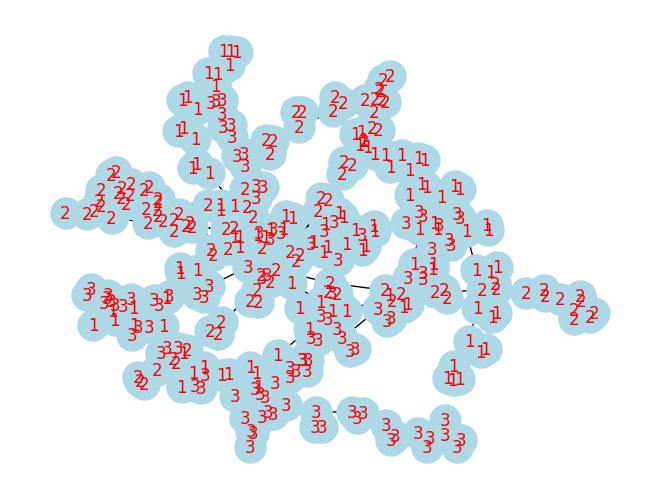

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph_from_bonds(df_bonds):
    # Create a new graph
    G = nx.Graph()

    # Add edges based on the ai and aj columns
    for _, row in df_bonds.iterrows():
        ai, aj = row['ai'], row['aj']
        nmer_ai, nmer_aj = row['nmer_ai'], row['nmer_aj']

        # Add edges between ai and aj
        G.add_edge(ai, aj)

        # Add the nmer value as a label to the nodes
        G.nodes[ai]['nmer'] = nmer_ai
        G.nodes[aj]['nmer'] = nmer_aj

    # Draw the graph with labels for each node
    pos = nx.spring_layout(G)  # Position the nodes
    labels = nx.get_node_attributes(G, 'nmer')  # Get the nmer labels
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=500, font_size=10)
    nx.draw_networkx_labels(G, pos, labels=labels, font_color='red', font_size=12)

    # Show the graph
    plt.show()

# Call the function with your dataframe
create_graph_from_bonds(df_bonds)


#### Parse Monomer

In [ ]:
parsed_data = parse_itp_file(itp_file_path_1mer)
df_bonds_1 = pd.DataFrame(parsed_data.get('bonds', []), columns=['ai', 'aj', 'funct', 'c0', 'c1'])
df_atoms_1 = pd.DataFrame(parsed_data.get('atoms', []), columns=['nr', 'type', 'resnr', 'residue', 'atom', 'cgnr', 'charge', 'mass'])

# Function to map atom types based on the atom number
def map_atom_types(df_atoms_1, df, columns):
    atom_to_type = df_atoms_1.set_index('nr')['atom_type'].to_dict()

    for col in columns:
        atom_col = 'atom_' + col  # Create new column name
        df[atom_col] = df[col].map(atom_to_type)  # Map atom type using atom number

    return df

# Apply split_atom_name to df_atoms_1
df_atoms_1 = split_atom_name(df_atoms_1)

# Now map atom types to df_bonds_1, df_angles, df_improper, df_proper
df_bonds_1 = map_atom_types(df_atoms_1, df_bonds_1, ['ai', 'aj'])
print(df_bonds_1)

      ai   aj funct      c0          c1 atom_ai atom_aj
0      2    1     1  0.1367  456892.800       C       C
1      3    2     1  0.1424  392459.200       C       C
2      4    3     1  0.1424  392459.200       C       C
3      5    1     1  0.1740  209200.000       S       C
4      6    1     1  0.1080  307105.600       H       C
..   ...  ...   ...     ...         ...     ...     ...
108  110  107     1  0.1090  284512.000       H       C
109    5    4     1  0.1760  209200.000       S       C
110   13   11     1  0.1424  392459.200       C       C
111   17   16     1  0.1760  209200.000       S       C
112   22   21     1  0.1367  456892.800       C       C

[113 rows x 7 columns]


### Separate Units

#### Separate Start Unit

In [ ]:
# Create df_atoms_start from df_atoms where nmer = 1
df_atoms_start = df_atoms[df_atoms['nmer'] == 1].copy()

# Create df_bonds_start from df_bonds where both nmer_ai and nmer_aj are 1
df_bonds_start = df_bonds[(df_bonds['nmer_ai'] == 1) & (df_bonds['nmer_aj'] == 1)].copy()

# Create df_angles_start from df_angles where nmer_ai, nmer_aj, and nmer_ak are all 1
df_angles_start = df_angles[(df_angles['nmer_ai'] == 1) &
                            (df_angles['nmer_aj'] == 1) &
                            (df_angles['nmer_ak'] == 1)].copy()

# Create df_improper_start from df_improper where nmer_ai, nmer_aj, nmer_ak, and nmer_al are all 1
df_improper_start = df_improper[(df_improper['nmer_ai'] == 1) &
                                (df_improper['nmer_aj'] == 1) &
                                (df_improper['nmer_ak'] == 1) &
                                (df_improper['nmer_al'] == 1)].copy()

# Create df_proper_start from df_proper where nmer_ai, nmer_aj, nmer_ak, and nmer_al are all 1
df_proper_start = df_proper[(df_proper['nmer_ai'] == 1) &
                            (df_proper['nmer_aj'] == 1) &
                            (df_proper['nmer_ak'] == 1) &
                            (df_proper['nmer_al'] == 1)].copy()

# Optionally, display the results
print(df_atoms_start)
print(df_bonds_start)
print(df_angles_start)
print(df_improper_start)
print(df_proper_start)

      nr      type resnr residue atom cgnr   charge    mass  nmer atom_type  \
0      1  opls_800     1     UNK  C00    1  -0.0242  12.011     1         C   
1      2  opls_801     1     UNK  C01    1  -0.1180  12.011     1         C   
2      3  opls_802     1     UNK  C02    1  -0.0301  12.011     1         C   
3      4  opls_803     1     UNK  C03    1  -0.0279  12.011     1         C   
4      5  opls_804     1     UNK  S04    1   0.0506   32.06     1         S   
..   ...       ...   ...     ...  ...  ...      ...     ...   ...       ...   
161  188  opls_893     1     UNK  H1A    1   0.0912   1.008     1         H   
162  189  opls_892     1     UNK  C1B    1  -0.2333  12.011     1         C   
163  190  opls_893     1     UNK  H1C    1   0.0826   1.008     1         H   
164  191  opls_893     1     UNK  H1D    1   0.0826   1.008     1         H   
165  192  opls_893     1     UNK  H1E    1   0.0826   1.008     1         H   

    atom_namnum  
0            00  
1            01

#### Separate End Unit

In [ ]:
# Create df_atoms_end from df_atoms where nmer = 1
df_atoms_end = df_atoms[df_atoms['nmer'] == 3].copy()

# Create df_bonds_end from df_bonds where both nmer_ai and nmer_aj are 1
df_bonds_end = df_bonds[(df_bonds['nmer_ai'] == 3) & (df_bonds['nmer_aj'] == 3)].copy()

# Create df_angles_end from df_angles where nmer_ai, nmer_aj, and nmer_ak are all 1
df_angles_end = df_angles[(df_angles['nmer_ai'] == 3) &
                            (df_angles['nmer_aj'] == 3) &
                            (df_angles['nmer_ak'] == 3)].copy()

# Create df_improper_end from df_improper where nmer_ai, nmer_aj, nmer_ak, and nmer_al are all 1
df_improper_end = df_improper[(df_improper['nmer_ai'] == 3) &
                                (df_improper['nmer_aj'] == 3) &
                                (df_improper['nmer_ak'] == 3) &
                                (df_improper['nmer_al'] == 3)].copy()

# Create df_proper_end from df_proper where nmer_ai, nmer_aj, nmer_ak, and nmer_al are all 1
df_proper_end = df_proper[(df_proper['nmer_ai'] == 3) &
                            (df_proper['nmer_aj'] == 3) &
                            (df_proper['nmer_ak'] == 3) &
                            (df_proper['nmer_al'] == 3)].copy()

# Optionally, display the results
print(df_atoms_end)
print(df_bonds_end)
print(df_angles_end)
print(df_improper_end)
print(df_proper_end)

      nr      type resnr residue atom cgnr   charge    mass  nmer atom_type  \
57    62  opls_861     1     UNK  C1R    3  -0.0243  12.011     3         C   
58    63  opls_862     1     UNK  C1S    3  -0.1181  12.011     3         C   
59    64  opls_863     1     UNK  S1T    3   0.0496   32.06     3         S   
60    65  opls_864     1     UNK  C1U    3  -0.0302  12.011     3         C   
61    66  opls_865     1     UNK  H1V    3   0.1063   1.008     3         H   
..   ...       ...   ...     ...  ...  ...      ...     ...   ...       ...   
321  388  opls_893     1     UNK  H1A    3   0.0912   1.008     3         H   
322  389  opls_892     1     UNK  C1B    3  -0.2334  12.011     3         C   
323  390  opls_893     1     UNK  H1C    3   0.0826   1.008     3         H   
324  391  opls_893     1     UNK  H1D    3   0.0826   1.008     3         H   
325  392  opls_893     1     UNK  H1E    3   0.0826   1.008     3         H   

    atom_namnum  
57           1R  
58           1S

#### Separate Middle Unit & Connection Params

In [ ]:
# Create df_atoms_mid from df_atoms where nmer = 2
df_atoms_mid = df_atoms[df_atoms['nmer'] == 2].copy()

# Create df_bonds_mid from df_bonds where nmer_ai or nmer_aj is 2
df_bonds_mid = df_bonds[(df_bonds['nmer_ai'] == 2) & (df_bonds['nmer_aj'] == 2)].copy()

# Create df_angles_mid from df_angles where nmer_ai, nmer_aj, or nmer_ak is 2
df_angles_mid = df_angles[(df_angles['nmer_ai'] == 2) &
                          (df_angles['nmer_aj'] == 2) &
                          (df_angles['nmer_ak'] == 2)].copy()

# Create df_improper_mid from df_improper where nmer_ai, nmer_aj, nmer_ak, or nmer_al is 2
df_improper_mid = df_improper[(df_improper['nmer_ai'] == 2) &
                              (df_improper['nmer_aj'] == 2) &
                              (df_improper['nmer_ak'] == 2) &
                              (df_improper['nmer_al'] == 2)].copy()

# Create df_proper_mid from df_proper where nmer_ai, nmer_aj, nmer_ak, or nmer_al is 2
df_proper_mid = df_proper[(df_proper['nmer_ai'] == 2) &
                          (df_proper['nmer_aj'] == 2) &
                          (df_proper['nmer_ak'] == 2) &
                          (df_proper['nmer_al'] == 2)].copy()

# Optionally, display the results
print(df_atoms_mid)
print(df_bonds_mid)
print(df_angles_mid)
print(df_improper_mid)
print(df_proper_mid)

      nr      type resnr residue atom cgnr   charge    mass  nmer atom_type  \
29    32  opls_831     1     UNK  C0W    2  -0.0238  12.011     2         C   
30    33  opls_832     1     UNK  C0X    2  -0.1181  12.011     2         C   
31    34  opls_833     1     UNK  S0Y    2   0.0507   32.06     2         S   
32    35  opls_834     1     UNK  C0Z    2  -0.0299  12.011     2         C   
33    36  opls_835     1     UNK  H10    2   0.1064   1.008     2         H   
..   ...       ...   ...     ...  ...  ...      ...     ...   ...       ...   
241  288  opls_893     1     UNK  H1A    2   0.0912   1.008     2         H   
242  289  opls_892     1     UNK  C1B    2  -0.2333  12.011     2         C   
243  290  opls_893     1     UNK  H1C    2   0.0826   1.008     2         H   
244  291  opls_893     1     UNK  H1D    2   0.0826   1.008     2         H   
245  292  opls_893     1     UNK  H1E    2   0.0826   1.008     2         H   

    atom_namnum  
29           0W  
30           0X

In [ ]:
# For Bonds: Grab rows where one atom is nmer = 1 and the other is nmer = 2
df_bonds_1_2 = df_bonds[((df_bonds['nmer_ai'] == 1) & (df_bonds['nmer_aj'] == 2)) |
                        ((df_bonds['nmer_ai'] == 2) & (df_bonds['nmer_aj'] == 1))].copy()

# For Angles: Grab rows where at least one atom is nmer = 1 and another is nmer = 2
df_angles_1_2 = df_angles[((df_angles['nmer_ai'] == 1) & ((df_angles['nmer_aj'] == 2) | (df_angles['nmer_ak'] == 2))) |
                          ((df_angles['nmer_aj'] == 1) & ((df_angles['nmer_ai'] == 2) | (df_angles['nmer_ak'] == 2))) |
                          ((df_angles['nmer_ak'] == 1) & ((df_angles['nmer_ai'] == 2) | (df_angles['nmer_aj'] == 2)))].copy()

# For Improper Dihedrals: Same logic, but for four atoms
df_improper_1_2 = df_improper[((df_improper['nmer_ai'] == 1) & ((df_improper['nmer_aj'] == 2) |
                                                                (df_improper['nmer_ak'] == 2) |
                                                                (df_improper['nmer_al'] == 2))) |
                              ((df_improper['nmer_aj'] == 1) & ((df_improper['nmer_ai'] == 2) |
                                                                (df_improper['nmer_ak'] == 2) |
                                                                (df_improper['nmer_al'] == 2))) |
                              ((df_improper['nmer_ak'] == 1) & ((df_improper['nmer_ai'] == 2) |
                                                                (df_improper['nmer_aj'] == 2) |
                                                                (df_improper['nmer_al'] == 2))) |
                              ((df_improper['nmer_al'] == 1) & ((df_improper['nmer_ai'] == 2) |
                                                                (df_improper['nmer_aj'] == 2) |
                                                                (df_improper['nmer_ak'] == 2)))].copy()

# For Proper Dihedrals: Same logic for proper dihedrals
df_proper_1_2 = df_proper[((df_proper['nmer_ai'] == 1) & ((df_proper['nmer_aj'] == 2) |
                                                          (df_proper['nmer_ak'] == 2) |
                                                          (df_proper['nmer_al'] == 2))) |
                          ((df_proper['nmer_aj'] == 1) & ((df_proper['nmer_ai'] == 2) |
                                                          (df_proper['nmer_ak'] == 2) |
                                                          (df_proper['nmer_al'] == 2))) |
                          ((df_proper['nmer_ak'] == 1) & ((df_proper['nmer_ai'] == 2) |
                                                          (df_proper['nmer_aj'] == 2) |
                                                          (df_proper['nmer_al'] == 2))) |
                          ((df_proper['nmer_al'] == 1) & ((df_proper['nmer_ai'] == 2) |
                                                          (df_proper['nmer_aj'] == 2) |
                                                          (df_proper['nmer_ak'] == 2)))].copy()

# Optionally, display the results
print(df_bonds_1_2)
print(df_angles_1_2)
print(df_improper_1_2)
print(df_proper_1_2)

    ai  aj funct      c0        c1  nmer_ai  nmer_aj atom_ai atom_aj
28  32   1     1  0.1424  392459.2        2        1       C       C
    ai  aj  ak funct     c0       c1  nmer_ai  nmer_aj  nmer_ak atom_ai  \
2    1  32  33     1    120  527.184        1        2        2       C   
3    1  32  34     1  119.4   711.28        1        2        2       C   
8    2   1  32     1    120  527.184        1        1        2       C   
18   5   1  32     1  119.4   711.28        1        1        2       S   

   atom_aj atom_ak  
2        C       C  
3        C       S  
8        C       C  
18       C       C  
    ai  aj  ak  al funct       c0      c1 c2  nmer_ai  nmer_aj  nmer_ak  \
3   32   1   2   5     4  180.000  10.460  2        2        1        1   
36  34  32   1  33     4  180.000  10.460  2        2        2        1   

    nmer_al atom_ai atom_aj atom_ak atom_al  
3         1       C       C       C       S  
36        2       S       C       C       C  
    ai  aj  ak  a

In [ ]:
# For Bonds: Grab rows where one atom is nmer = 2 and the other is nmer = 3
df_bonds_2_3 = df_bonds[((df_bonds['nmer_ai'] == 2) & (df_bonds['nmer_aj'] == 3)) |
                        ((df_bonds['nmer_ai'] == 3) & (df_bonds['nmer_aj'] == 2))].copy()

# For Angles: Grab rows where at least one atom is nmer = 2 and another is nmer = 3
df_angles_2_3 = df_angles[((df_angles['nmer_ai'] == 2) & ((df_angles['nmer_aj'] == 3) | (df_angles['nmer_ak'] == 3))) |
                          ((df_angles['nmer_aj'] == 2) & ((df_angles['nmer_ai'] == 3) | (df_angles['nmer_ak'] == 3))) |
                          ((df_angles['nmer_ak'] == 2) & ((df_angles['nmer_ai'] == 3) | (df_angles['nmer_aj'] == 3)))].copy()

# For Improper Dihedrals: Same logic, but for four atoms
df_improper_2_3 = df_improper[((df_improper['nmer_ai'] == 2) & ((df_improper['nmer_aj'] == 3) |
                                                                (df_improper['nmer_ak'] == 3) |
                                                                (df_improper['nmer_al'] == 3))) |
                              ((df_improper['nmer_aj'] == 2) & ((df_improper['nmer_ai'] == 3) |
                                                                (df_improper['nmer_ak'] == 3) |
                                                                (df_improper['nmer_al'] == 3))) |
                              ((df_improper['nmer_ak'] == 2) & ((df_improper['nmer_ai'] == 3) |
                                                                (df_improper['nmer_aj'] == 3) |
                                                                (df_improper['nmer_al'] == 3))) |
                              ((df_improper['nmer_al'] == 2) & ((df_improper['nmer_ai'] == 3) |
                                                                (df_improper['nmer_aj'] == 3) |
                                                                (df_improper['nmer_ak'] == 3)))].copy()

# For Proper Dihedrals: Same logic for proper dihedrals
df_proper_2_3 = df_proper[((df_proper['nmer_ai'] == 2) & ((df_proper['nmer_aj'] == 3) |
                                                          (df_proper['nmer_ak'] == 3) |
                                                          (df_proper['nmer_al'] == 3))) |
                          ((df_proper['nmer_aj'] == 2) & ((df_proper['nmer_ai'] == 3) |
                                                          (df_proper['nmer_ak'] == 3) |
                                                          (df_proper['nmer_al'] == 3))) |
                          ((df_proper['nmer_ak'] == 2) & ((df_proper['nmer_ai'] == 3) |
                                                          (df_proper['nmer_aj'] == 3) |
                                                          (df_proper['nmer_al'] == 3))) |
                          ((df_proper['nmer_al'] == 2) & ((df_proper['nmer_ai'] == 3) |
                                                          (df_proper['nmer_aj'] == 3) |
                                                          (df_proper['nmer_ak'] == 3)))].copy()

# Optionally, display the results
print(df_bonds_2_3)
print(df_angles_2_3)
print(df_improper_2_3)
print(df_proper_2_3)

    ai  aj funct      c0        c1  nmer_ai  nmer_aj atom_ai atom_aj
56  62  57     1  0.1424  392459.2        3        2       C       C
     ai  aj  ak funct     c0       c1  nmer_ai  nmer_aj  nmer_ak atom_ai  \
98   54  57  62     1  119.4   711.28        2        2        3       S   
101  55  57  62     1    120  527.184        2        2        3       C   
102  57  62  63     1    120  527.184        2        3        3       C   
103  57  62  64     1  119.4   711.28        2        3        3       C   

    atom_aj atom_ak  
98        C       C  
101       C       C  
102       C       C  
103       C       S  
    ai  aj  ak  al funct       c0      c1 c2  nmer_ai  nmer_aj  nmer_ak  \
11  62  57  54  55     4  180.000  10.460  2        3        2        2   
33  64  62  57  63     4  180.000  10.460  2        3        3        2   

    nmer_al atom_ai atom_aj atom_ak atom_al  
11        2       C       C       S       C  
33        3       S       C       C       C  
     ai

#### Set up Renumbering Matrix

##### Renumber Start, Mid, End for trimer

In [ ]:
import pandas as pd

# Ensure consistent datatypes for df_bonds_1 if not already specified
# Assuming the following desired datatypes:
# 'ai' and 'aj' as integers, 'funct' as integer, 'c0' and 'c1' as floats

df_bonds_1 = df_bonds_1.astype({
    'ai': 'int',
    'aj': 'int',
    'funct': 'int',
    'c0': 'float',
    'c1': 'float'
})

# Values in hs_on_monomer
start_value, end_value = int(hs_on_monomer[0]), int(hs_on_monomer[1])

# Create df_bonds_1_start: remove rows where 'ai' or 'aj' matches the end_value
df_bonds_1_start = df_bonds_1[~((df_bonds_1['ai'] == end_value) | (df_bonds_1['aj'] == end_value))]

# Create df_bonds_1_end: remove rows where 'ai' or 'aj' matches the start_value
df_bonds_1_end = df_bonds_1[~((df_bonds_1['ai'] == start_value) | (df_bonds_1['aj'] == start_value))]

# Create df_bonds_1_mid as a copy of df_bonds_1_start
df_bonds_1_mid = df_bonds_1[~((df_bonds_1['ai'] == start_value) | (df_bonds_1['aj'] == start_value) |
                              (df_bonds_1['ai'] == end_value) | (df_bonds_1['aj'] == end_value))]

# Display the resulting DataFrames to check them
print("df_bonds_1_start:")
print(df_bonds_1_start)

print("\ndf_bonds_1_end:")
print(df_bonds_1_end)

print("\ndf_bonds_1_mid:")
print(df_bonds_1_mid)


df_bonds_1_start:
      ai   aj  funct      c0        c1 atom_ai atom_aj
0      2    1      1  0.1367  456892.8       C       C
1      3    2      1  0.1424  392459.2       C       C
2      4    3      1  0.1424  392459.2       C       C
3      5    1      1  0.1740  209200.0       S       C
4      6    1      1  0.1080  307105.6       H       C
..   ...  ...    ...     ...       ...     ...     ...
108  110  107      1  0.1090  284512.0       H       C
109    5    4      1  0.1760  209200.0       S       C
110   13   11      1  0.1424  392459.2       C       C
111   17   16      1  0.1760  209200.0       S       C
112   22   21      1  0.1367  456892.8       C       C

[112 rows x 7 columns]

df_bonds_1_end:
      ai   aj  funct      c0        c1 atom_ai atom_aj
0      2    1      1  0.1367  456892.8       C       C
1      3    2      1  0.1424  392459.2       C       C
2      4    3      1  0.1424  392459.2       C       C
3      5    1      1  0.1740  209200.0       S       C
5     

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a graph from a dataframe
def create_graph_from_df(df, name):
    # Initialize the graph
    g = nx.Graph()

    # Add edges and attributes
    for _, row in df.iterrows():
        g.add_edge(row['ai'], row['aj'])
        g.nodes[row['ai']]['atom'] = row['atom_ai']
        g.nodes[row['aj']]['atom'] = row['atom_aj']

    # Prepare node labels to include both atom type and vertex number
    node_labels = {node: f"{data['atom']}{node}" for node, data in g.nodes(data=True)}

    return g

# Create graphs for each dataframe
g_bonds_1_start = create_graph_from_df(df_bonds_1_start, "g_bonds_1_start")
g_bonds_1_end = create_graph_from_df(df_bonds_1_end, "g_bonds_1_end")
g_bonds_1_mid = create_graph_from_df(df_bonds_1_mid, "g_bonds_1_mid")
g_bonds_start = create_graph_from_df(df_bonds_start, "g_bonds_start")
g_bonds_end = create_graph_from_df(df_bonds_end, "g_bonds_end")
g_bonds_mid = create_graph_from_df(df_bonds_mid, "g_bonds_mid")

In [ ]:
import networkx as nx

# Custom node match function that checks both atom type and node label
def node_match(n1, n2):
    return n1['atom'] == n2['atom']

# Check isomorphism between pairs
start_isomorphic = nx.is_isomorphic(g_bonds_1_start, g_bonds_start, node_match=node_match)
mid_isomorphic = nx.is_isomorphic(g_bonds_1_mid, g_bonds_mid, node_match=node_match)
end_isomorphic = nx.is_isomorphic(g_bonds_1_end, g_bonds_end, node_match=node_match)

# Output the results
print(f"Start graphs are isomorphic: {start_isomorphic}")
print(f"Mid graphs are isomorphic: {mid_isomorphic}")
print(f"End graphs are isomorphic: {end_isomorphic}")


Start graphs are isomorphic: True
Mid graphs are isomorphic: True
End graphs are isomorphic: True


In [ ]:
import networkx as nx
import pandas as pd

# Function to create a mapping dataframe based on isomorphic mapping
def create_mapping_df(g1, g2):
    # Define the node matcher and check isomorphism
    matcher = nx.isomorphism.GraphMatcher(g1, g2, node_match=node_match)
    if not matcher.is_isomorphic():
        print("Graphs are not isomorphic.")
        return None

    # Create dataframe from node mapping
    mapping = matcher.mapping  # This maps nodes from g1 to g2
    df_mapping = pd.DataFrame({
        'old_1': list(mapping.keys()),         # Original nodes from g1
        'old_3': list(mapping.values()),       # Corresponding nodes in g2
        'new_nr': range(len(mapping))          # New numbering based on isomorphism
    })
    return df_mapping

# Generate each mapping dataframe
nr_matrix_start = create_mapping_df(g_bonds_1_start, g_bonds_start)
nr_matrix_mid = create_mapping_df(g_bonds_1_mid, g_bonds_mid)
nr_matrix_end = create_mapping_df(g_bonds_1_end, g_bonds_end)

# Display the mapping dataframes
print("nr_matrix_start:")
print(nr_matrix_start)
print("\nnr_matrix_mid:")
print(nr_matrix_mid)
print("\nnr_matrix_end:")
print(nr_matrix_end)


nr_matrix_start:
     old_1  old_3  new_nr
0       21      2       0
1       22      1       1
2       19      3       2
3       18      4       3
4       20      5       4
..     ...    ...     ...
104    106    188     104
105    107    189     105
106    108    190     106
107    109    191     107
108    110    192     108

[109 rows x 3 columns]

nr_matrix_mid:
     old_1  old_3  new_nr
0        2     33       0
1        1     32       1
2        5     34       2
3        3     35       3
4        7     36       4
..     ...    ...     ...
103    106    288     103
104    107    289     104
105    108    290     105
106    109    291     106
107    110    292     107

[108 rows x 3 columns]

nr_matrix_end:
     old_1  old_3  new_nr
0        2     63       0
1        1     62       1
2        5     64       2
3        3     65       3
4        7     66       4
..     ...    ...     ...
104    106    388     104
105    107    389     105
106    108    390     106
107    109    391  

In [ ]:
def process_mapping_df(df):
    # Convert old_1 to integers
    df['old_1'] = df['old_1'].astype(int)

    # Sort by old_1
    df = df.sort_values(by='old_1').reset_index(drop=True)

    # Update new_nr to be index + 1
    df['new_nr'] = df.index + 1

    return df

# Process each mapping dataframe
nr_matrix_start = process_mapping_df(nr_matrix_start)
nr_matrix_mid = process_mapping_df(nr_matrix_mid)
nr_matrix_end = process_mapping_df(nr_matrix_end)

# Display the updated dataframes
print("Updated nr_matrix_start:")
print(nr_matrix_start)
print("\nUpdated nr_matrix_mid:")
print(nr_matrix_mid)
print("\nUpdated nr_matrix_end:")
print(nr_matrix_end)


Updated nr_matrix_start:
     old_1  old_3  new_nr
0        1     21       1
1        2     20       2
2        3     18       3
3        4     17       4
4        5     19       5
..     ...    ...     ...
104    106    188     105
105    107    189     106
106    108    190     107
107    109    191     108
108    110    192     109

[109 rows x 3 columns]

Updated nr_matrix_mid:
     old_1  old_3  new_nr
0        1     32       1
1        2     33       2
2        3     35       3
3        4     37       4
4        5     34       5
..     ...    ...     ...
103    106    288     104
104    107    289     105
105    108    290     106
106    109    291     107
107    110    292     108

[108 rows x 3 columns]

Updated nr_matrix_end:
     old_1  old_3  new_nr
0        1     62       1
1        2     63       2
2        3     65       3
3        4     67       4
4        5     64       5
..     ...    ...     ...
104    106    388     105
105    107    389     106
106    108    390    

#### Error Check (Disconnected Pieces & 1-3 Connections)


In [ ]:
def check_nmer_values(df_angles, df_improper, df_proper):
    valid_nmer_values = {1, 2, 3}  # Only allow nmer values of 1, 2, or 3

    # List of columns to check for each dataframe
    angle_columns = ['nmer_ai', 'nmer_aj', 'nmer_ak']
    dihedral_columns = ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']

    # Helper function to check for the presence of 1, 2, and 3 in the same row
    def check_for_1_2_3(row):
        nmer_set = set(row)
        return {1, 2, 3}.issubset(nmer_set)

    # Helper function to check for values other than 1, 2, or 3
    def check_for_invalid_nmer(row):
        return not set(row).issubset(valid_nmer_values)

    # Check angles dataframe for 1_2_3 connection and invalid nmer values
    for idx, row in df_angles[angle_columns].iterrows():
        try:
            if check_for_1_2_3(row):
                print(f"Error: Connection between units is too close in row {idx}. "
                      f"Problematic row: {row.values.tolist()} "
                      "There must be no dihedral with connections from unit 1 to unit 3. "
                      "(Modify code to include these connections in PolyX_2.0)")
            elif check_for_invalid_nmer(row):
                print(f"Error: Invalid nmer values in row {idx}. "
                      f"Problematic row: {row.values.tolist()} "
                      "Only nmer values of 1, 2, and 3 are allowed.")
        except Exception as e:
            print(f"Exception occurred in angles at row {idx}: {e}")

    # Check improper dihedrals for 1_2_3 connection and invalid nmer values
    for idx, row in df_improper[dihedral_columns].iterrows():
        try:
            if check_for_1_2_3(row):
                print(f"Error: Connection between units is too close in row {idx}. "
                      f"Problematic row: {row.values.tolist()} "
                      "There must be no dihedral with connections from unit 1 to unit 3. "
                      "(Modify code to include these connections in PolyX_2.0)")
            elif check_for_invalid_nmer(row):
                print(f"Error: Invalid nmer values in row {idx}. "
                      f"Problematic row: {row.values.tolist()} "
                      "Only nmer values of 1, 2, and 3 are allowed.")
        except Exception as e:
            print(f"Exception occurred in improper dihedrals at row {idx}: {e}")

    # Check proper dihedrals for 1_2_3 connection and invalid nmer values
    for idx, row in df_proper[dihedral_columns].iterrows():
        try:
            if check_for_1_2_3(row):
                print(f"Error: Connection between units is too close in row {idx}. "
                      f"Problematic row: {row.values.tolist()} "
                      "There must be no dihedral with connections from unit 1 to unit 3. "
                      "(Modify code to include these connections in PolyX_2.0)")
            elif check_for_invalid_nmer(row):
                print(f"Error: Invalid nmer values in row {idx}. "
                      f"Problematic row: {row.values.tolist()} "
                      "Only nmer values of 1, 2, and 3 are allowed.")
        except Exception as e:
            print(f"Exception occurred in proper dihedrals at row {idx}: {e}")

# Call the function with your dataframes
check_nmer_values(df_angles, df_improper, df_proper)


Error: Invalid nmer values in row 106. Problematic row: [0, 2, 2] Only nmer values of 1, 2, and 3 are allowed.
Error: Invalid nmer values in row 125. Problematic row: [0, 3, 3] Only nmer values of 1, 2, and 3 are allowed.
Error: Invalid nmer values in row 126. Problematic row: [0, 3, 3] Only nmer values of 1, 2, and 3 are allowed.
Error: Invalid nmer values in row 159. Problematic row: [0, 3, 3] Only nmer values of 1, 2, and 3 are allowed.


### Renumbering Units

In [ ]:
print(nr_matrix_end, nr_matrix_mid, nr_matrix_start)

     old_1  old_3  new_nr
0        1     62       1
1        2     63       2
2        3     65       3
3        4     67       4
4        5     64       5
..     ...    ...     ...
104    106    388     105
105    107    389     106
106    108    390     107
107    109    391     108
108    110    392     109

[109 rows x 3 columns]      old_1  old_3  new_nr
0        1     32       1
1        2     33       2
2        3     35       3
3        4     37       4
4        5     34       5
..     ...    ...     ...
103    106    288     104
104    107    289     105
105    108    290     106
106    109    291     107
107    110    292     108

[108 rows x 3 columns]      old_1  old_3  new_nr
0        1     21       1
1        2     20       2
2        3     18       3
3        4     17       4
4        5     19       5
..     ...    ...     ...
104    106    188     105
105    107    189     106
106    108    190     107
107    109    191     108
108    110    192     109

[109 rows x 3 c

In [ ]:
# Create df_renumber from df_atoms
df_renumber = df_atoms[['nmer', 'nr']].copy()

# Rename 'nr' to 'nr_original'
df_renumber.rename(columns={'nr': 'nr_original'}, inplace=True)

# Add the empty 'nr_renumbered' column
df_renumber['nr_renumbered'] = None

# Reorder df_renumber based on the 'nmer' column (least to greatest)
df_renumber = df_renumber.sort_values(by='nmer', ascending=True).reset_index(drop=True)

# Calculate the total number of rows where nmer = 1
start_size = df_renumber[df_renumber['nmer'] == 1].shape[0]

# Calculate the total number of rows where nmer = 2
mid_size = df_renumber[df_renumber['nmer'] == 2].shape[0]

# Optionally, display the new dataframe
print(df_renumber)

     nmer  nr_original nr_renumbered
0       1            1          None
1       1          125          None
2       1          126          None
3       1          127          None
4       1          128          None
..    ...          ...           ...
321     3          304          None
322     3          303          None
323     3           86          None
324     3          313          None
325     3          392          None

[326 rows x 3 columns]


#### Renumber Start Unit

In [ ]:
# Step 1: Filter df_bonds for rows where both nmer_ai and nmer_aj are 1
dbs = df_bonds[(df_bonds['nmer_ai'] == 1) & (df_bonds['nmer_aj'] == 1)].copy()

# Step 2: Build a graph from the filtered df_bonds data
G = nx.Graph()
for _, row in dbs.iterrows():
    G.add_edge(row['ai'], row['aj'])

# Step 3: Create a mapping from nr_original to new_nr using nr_matrix_start
# This assumes nr_matrix_start has columns ['old_3', 'new_nr']
nr_mapping = dict(zip(nr_matrix_start['old_3'], nr_matrix_start['new_nr']))

# Step 4: Update df_renumber's 'nr_renumbered' column only where 'nmer' is 1 and 'nr_original' exists in nr_mapping
df_renumber.loc[(df_renumber['nmer'] == 1) &
                (df_renumber['nr_original'].isin(nr_mapping.keys())),
                'nr_renumbered'] = df_renumber['nr_original'].map(nr_mapping)

# Step 5: Ensure that 'nr_renumbered' column is integer type
df_renumber['nr_renumbered'] = df_renumber['nr_renumbered'].astype('Int64')

# Optionally, display the updated df_renumber
print(df_renumber)


     nmer  nr_original  nr_renumbered
0       1            1             22
1       1          125             52
2       1          126             53
3       1          127             54
4       1          128             55
..    ...          ...            ...
321     3          304           <NA>
322     3          303           <NA>
323     3           86           <NA>
324     3          313           <NA>
325     3          392           <NA>

[326 rows x 3 columns]


#### Renumber End Unit

In [ ]:
# Step 1: Filter df_bonds for rows where both nmer_ai and nmer_aj are 3
dbs = df_bonds[(df_bonds['nmer_ai'] == 3) & (df_bonds['nmer_aj'] == 3)].copy()

# Step 2: Build a graph from the filtered df_bonds data
G = nx.Graph()
for _, row in dbs.iterrows():
    G.add_edge(row['ai'], row['aj'])

# Step 3: Create a mapping from old_3 to new_nr using nr_matrix_end
# This assumes nr_matrix_end has columns ['old_3', 'new_nr']
nr_mapping = dict(zip(nr_matrix_end['old_3'], nr_matrix_end['new_nr']))

# Step 4: Update df_renumber's 'nr_renumbered' column only for rows where 'nmer' is 3
# and 'nr_original' exists in the nr_mapping
df_renumber.loc[(df_renumber['nmer'] == 3) &
                (df_renumber['nr_original'].isin(nr_mapping.keys())),
                'nr_renumbered'] = df_renumber['nr_original'].map(nr_mapping)

# Step 5: Ensure that 'nr_renumbered' column is integer type
df_renumber['nr_renumbered'] = df_renumber['nr_renumbered'].astype('Int64')

# Step 6: Update the 'nmer' column where 'nmer' equals 3 to the value of 'n'
df_renumber.loc[df_renumber['nmer'] == 3, 'nmer'] = n

# Optionally, display the updated df_renumber
print(df_renumber)


     nmer  nr_original  nr_renumbered
0       1            1             22
1       1          125             52
2       1          126             53
3       1          127             54
4       1          128             55
..    ...          ...            ...
321    21          304             31
322    21          303             30
323    21           86             27
324    21          313             40
325    21          392            109

[326 rows x 3 columns]


#### Renumber Mid Unit

In [ ]:
# Step 1: Filter df_bonds for rows where both nmer_ai and nmer_aj are 2
dbm = df_bonds[(df_bonds['nmer_ai'] == 2) & (df_bonds['nmer_aj'] == 2)].copy()

# Step 2: Build a graph from the filtered df_bonds data
G = nx.Graph()
for _, row in dbm.iterrows():
    G.add_edge(row['ai'], row['aj'])

# Step 3: Create a mapping from old_3 to new_nr using nr_matrix_mid
# This assumes nr_matrix_mid has columns ['old_3', 'new_nr']
nr_mapping = dict(zip(nr_matrix_mid['old_3'], nr_matrix_mid['new_nr']))

# Step 4: Update df_renumber's 'nr_renumbered' column only for rows where 'nmer' is 2
# and 'nr_original' exists in nr_mapping
df_renumber.loc[(df_renumber['nmer'] == 2) &
                (df_renumber['nr_original'].isin(nr_mapping.keys())),
                'nr_renumbered'] = df_renumber['nr_original'].map(nr_mapping)

# Step 5: Ensure that 'nr_renumbered' column is integer type
df_renumber['nr_renumbered'] = df_renumber['nr_renumbered'].astype('Int64')

# Step 6: Filter rows where nmer = 2 to prepare for further additions
df_nmer_2 = df_renumber[df_renumber['nmer'] == 2].copy()

# Step 7: Initialize an empty list to store the new rows that will be appended
new_rows = []

# Step 8: Loop from 1 to (n-3) to create additional rows with incremented 'nmer' values
for i in range(1, n - 2):
    # Copy the rows and increment the 'nmer' value by i
    df_copy = df_nmer_2.copy()
    df_copy['nmer'] = df_copy['nmer'] + i

    # Append these rows to the new_rows list
    new_rows.append(df_copy)

# Step 9: Concatenate the original dataframe with the new rows
if new_rows:  # If there are new rows to append
    df_new_rows = pd.concat(new_rows, ignore_index=True)
    df_renumber = pd.concat([df_renumber, df_new_rows], ignore_index=True)

# Optionally, display the updated df_renumber
print(df_renumber)

      nmer  nr_original  nr_renumbered
0        1            1             22
1        1          125             52
2        1          126             53
3        1          127             54
4        1          128             55
...    ...          ...            ...
2265    20           33              2
2266    20           34              5
2267    20           35              3
2268    20           36              6
2269    20           38             23

[2270 rows x 3 columns]


#### Final Renumbering

In [ ]:
# Step 1: Sort df_renumber by nmer to ensure correct order
df_renumber = df_renumber.sort_values(by='nmer', ascending=True).reset_index(drop=True)

# Step 2: Get the unique nmer values and iterate over them
unique_nmers = df_renumber['nmer'].unique()

for current_nmer in unique_nmers:
    if current_nmer > n:
        break  # Stop when we reach nmer = n

    # Step 3: Count the number of rows with nmer less than the current nmer
    num_rows_less_than_current = df_renumber[df_renumber['nmer'] < current_nmer].shape[0]

    # Step 4: Adjust 'nr_renumbered' by adding the cumulative offset for rows with the current nmer
    df_renumber.loc[df_renumber['nmer'] == current_nmer, 'nr_renumbered'] += num_rows_less_than_current

# Optionally, display the updated df_renumber
print(df_renumber)


      nmer  nr_original  nr_renumbered
0        1            1             22
1        1          103             30
2        1          104             31
3        1          171             88
4        1          170             86
...    ...          ...            ...
2265    21          365           2243
2266    21          364           2242
2267    21          362           2240
2268    21          375           2253
2269    21          313           2201

[2270 rows x 3 columns]


## Create Middle-Middle Connection Parameters

### Graph Isomorphism to Map the Mid-Mid Connection

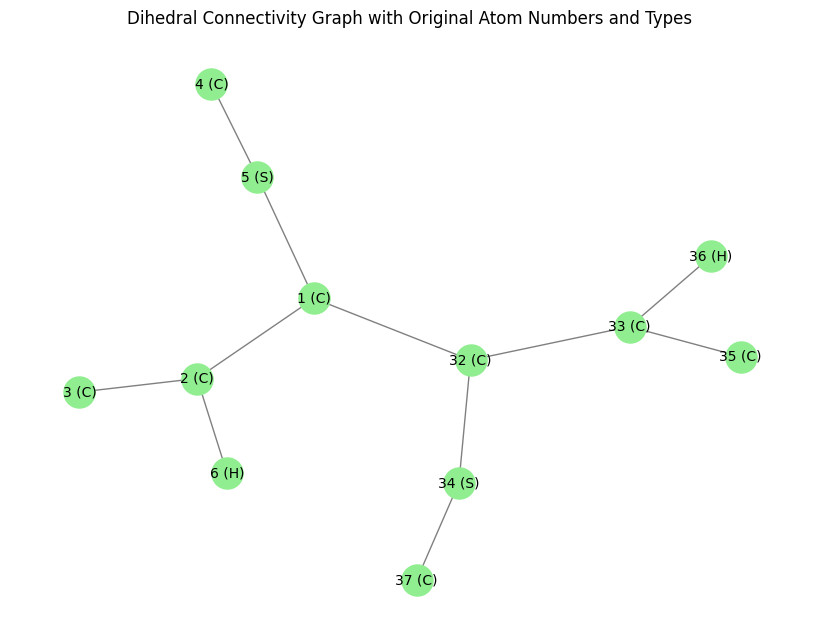

In [ ]:
# Adjust the label creation to ensure that the original atom indices from the dataframe are used
def create_graph_with_original_labels(df_proper_1_2):
    G = nx.Graph()  # Create an empty graph

    # Helper function to add edges and nodes from a dataframe
    def add_dihedral_edges(df):
        for _, row in df.iterrows():
            # Get the atom indices
            ai, aj, ak, al = row['ai'], row['aj'], row['ak'], row['al']
            atom_ai, atom_aj, atom_ak, atom_al = row['atom_ai'], row['atom_aj'], row['atom_ak'], row['atom_al']

            # Add nodes with their respective atom types and numbers as labels (keeping original indices)
            G.add_node(ai, label=f"{ai} ({atom_ai})")
            G.add_node(aj, label=f"{aj} ({atom_aj})")
            G.add_node(ak, label=f"{ak} ({atom_ak})")
            G.add_node(al, label=f"{al} ({atom_al})")

            # Add edges between the atoms
            G.add_edge(ai, aj)  # ai-aj
            G.add_edge(aj, ak)  # aj-ak
            G.add_edge(ak, al)  # ak-al

    # Add edges from both improper and proper dihedrals
    add_dihedral_edges(df_proper_1_2)

    return G

# Create the graph from df_improper_1_2 and df_proper_1_2 using the original atom numbers
G_1_2 = create_graph_with_original_labels(df_proper_1_2)

# Draw the graph with the original atom numbers and their types as labels
pos = nx.spring_layout(G_1_2)  # Define the layout of the graph
labels = nx.get_node_attributes(G_1_2, 'label')  # Get the labels with original atom numbers and types

plt.figure(figsize=(8, 6))  # Set the figure size
nx.draw(G_1_2, pos, with_labels=True, labels=labels, node_size=500, node_color="lightgreen", font_size=10, font_color="black", edge_color="gray")
plt.title("Dihedral Connectivity Graph with Original Atom Numbers and Types")
plt.show()

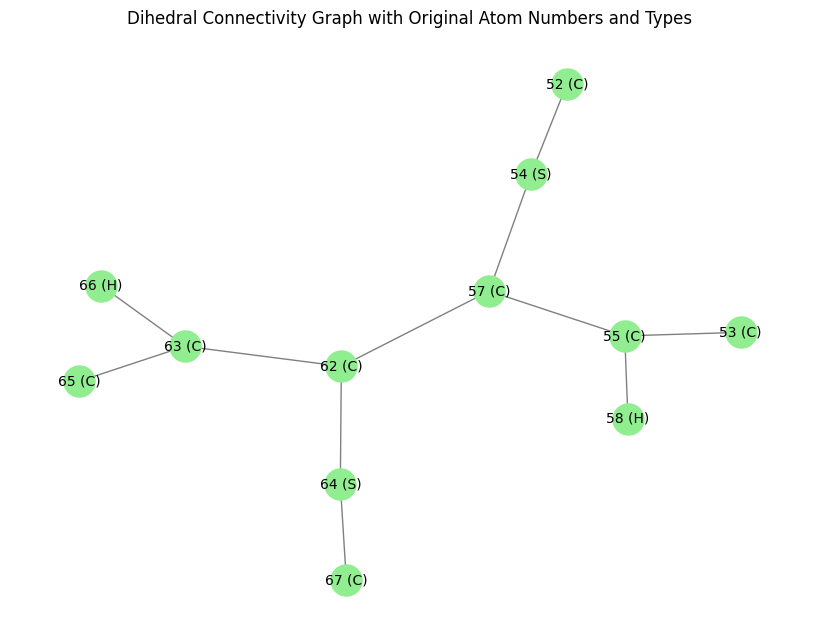

In [ ]:
# Adjust the label creation to ensure that the original atom indices from the dataframe are used
def create_graph_with_original_labels(df_proper_2_3):
    G = nx.Graph()  # Create an empty graph

    # Helper function to add edges and nodes from a dataframe
    def add_dihedral_edges(df):
        for _, row in df.iterrows():
            # Get the atom indices
            ai, aj, ak, al = row['ai'], row['aj'], row['ak'], row['al']
            atom_ai, atom_aj, atom_ak, atom_al = row['atom_ai'], row['atom_aj'], row['atom_ak'], row['atom_al']

            # Add nodes with their respective atom types and numbers as labels (keeping original indices)
            G.add_node(ai, label=f"{ai} ({atom_ai})")
            G.add_node(aj, label=f"{aj} ({atom_aj})")
            G.add_node(ak, label=f"{ak} ({atom_ak})")
            G.add_node(al, label=f"{al} ({atom_al})")

            # Add edges between the atoms
            G.add_edge(ai, aj)  # ai-aj
            G.add_edge(aj, ak)  # aj-ak
            G.add_edge(ak, al)  # ak-al

    # Add edges from both improper and proper dihedrals
    add_dihedral_edges(df_proper_2_3)

    return G

# Create the graph from df_improper_1_2 and df_proper_2_3 using the original atom numbers
G_2_3 = create_graph_with_original_labels(df_proper_2_3)

# Draw the graph with the original atom numbers and their types as labels
pos = nx.spring_layout(G_2_3)  # Define the layout of the graph
labels = nx.get_node_attributes(G_2_3, 'label')  # Get the labels with original atom numbers and types

plt.figure(figsize=(8, 6))  # Set the figure size
nx.draw(G_2_3, pos, with_labels=True, labels=labels, node_size=500, node_color="lightgreen", font_size=10, font_color="black", edge_color="gray")
plt.title("Dihedral Connectivity Graph with Original Atom Numbers and Types")
plt.show()

In [ ]:
# Create the connectivity_map dataframe with initial values
connectivity_map = pd.DataFrame({
    '1_2': dh1,
    '2_3': dh2
})

# Graph G1 (1_2) and G2 (2_3) should have been defined earlier. We'll now try to match them.
GM = isomorphism.GraphMatcher(G_1_2, G_2_3)

if GM.is_isomorphic():
    # If the graphs are isomorphic, get the node mapping and extend connectivity_map
    node_map = GM.mapping
    print("Graph isomorphism found. Mapping:")
    for key in node_map:
        print(f"{key} (from 1_2) -> {node_map[key]} (from 2_3)")

        # Add the mapping to the connectivity_map
        if key not in connectivity_map['1_2'].values:
            new_row = pd.DataFrame({'1_2': [key], '2_3': [node_map[key]]})
            connectivity_map = pd.concat([connectivity_map, new_row], ignore_index=True)

else:
    print("The graphs are not isomorphic.")

# Display the updated connectivity_map
print("\nUpdated connectivity_map after graph mapping:")
print(connectivity_map)

Graph isomorphism found. Mapping:
32 (from 1_2) -> 62 (from 2_3)
1 (from 1_2) -> 57 (from 2_3)
5 (from 1_2) -> 54 (from 2_3)
4 (from 1_2) -> 52 (from 2_3)
2 (from 1_2) -> 55 (from 2_3)
3 (from 1_2) -> 53 (from 2_3)
6 (from 1_2) -> 58 (from 2_3)
33 (from 1_2) -> 63 (from 2_3)
34 (from 1_2) -> 64 (from 2_3)
35 (from 1_2) -> 65 (from 2_3)
36 (from 1_2) -> 66 (from 2_3)
37 (from 1_2) -> 67 (from 2_3)

Updated connectivity_map after graph mapping:
    1_2  2_3
0     5   54
1     1   57
2    32   62
3    34   64
4     4   52
5     2   55
6     3   53
7     6   58
8    33   63
9    35   65
10   36   66
11   37   67


In [ ]:
# Step 1: Add nmer_1_2 by mapping the atom numbers in the '1_2' column to their corresponding 'nmer' in df_atoms
connectivity_map['nmer_1_2'] = connectivity_map['1_2'].map(df_atoms.set_index('nr')['nmer'])

# Step 2: Add nmer_2_3 by mapping the atom numbers in the '2_3' column to their corresponding 'nmer' in df_atoms
connectivity_map['nmer_2_3'] = connectivity_map['2_3'].map(df_atoms.set_index('nr')['nmer'])

# Step 3: Display the updated connectivity_map
print("\nUpdated connectivity_map with nmer_1_2 and nmer_2_3:")
print(connectivity_map)


Updated connectivity_map with nmer_1_2 and nmer_2_3:
    1_2  2_3  nmer_1_2  nmer_2_3
0     5   54         1         2
1     1   57         1         2
2    32   62         2         3
3    34   64         2         3
4     4   52         1         2
5     2   55         1         2
6     3   53         1         2
7     6   58         1         2
8    33   63         2         3
9    35   65         2         3
10   36   66         2         3
11   37   67         2         3


### Create Mid-Mid Connection Dataframes

In [ ]:
df_bonds_2_2 = df_bonds_1_2.copy()
df_angles_2_2 = df_angles_1_2.copy()
df_improper_2_2 = df_improper_1_2.copy()
df_proper_2_2 = df_proper_1_2.copy()

print(df_bonds_2_2)
print(df_angles_2_2)
print(df_improper_2_2)
print(df_proper_2_2)

    ai  aj funct      c0        c1  nmer_ai  nmer_aj atom_ai atom_aj
28  32   1     1  0.1424  392459.2        2        1       C       C
    ai  aj  ak funct     c0       c1  nmer_ai  nmer_aj  nmer_ak atom_ai  \
2    1  32  33     1    120  527.184        1        2        2       C   
3    1  32  34     1  119.4   711.28        1        2        2       C   
8    2   1  32     1    120  527.184        1        1        2       C   
18   5   1  32     1  119.4   711.28        1        1        2       S   

   atom_aj atom_ak  
2        C       C  
3        C       S  
8        C       C  
18       C       C  
    ai  aj  ak  al funct       c0      c1 c2  nmer_ai  nmer_aj  nmer_ak  \
3   32   1   2   5     4  180.000  10.460  2        2        1        1   
36  34  32   1  33     4  180.000  10.460  2        2        2        1   

    nmer_al atom_ai atom_aj atom_ak atom_al  
3         1       C       C       C       S  
36        2       S       C       C       C  
    ai  aj  ak  a

In [ ]:
def update_atom_indices(df, connectivity_map, nmer_columns, atom_columns):
    """
    Update atom indices in a dataframe based on connectivity_map.

    Parameters:
    - df: The dataframe containing the nmer and atom columns (e.g., df_bonds_2_2, df_angles_2_2).
    - connectivity_map: The mapping dataframe containing the '1_2' and '2_3' columns.
    - nmer_columns: The columns to check for nmer values (e.g., ['nmer_ai', 'nmer_aj', 'nmer_ak']).
    - atom_columns: The corresponding atom columns to update (e.g., ['ai', 'aj', 'ak']).
    """
    for nmer_col, atom_col in zip(nmer_columns, atom_columns):
        # Find rows where nmer is 1
        rows_to_update = df[df[nmer_col] == 1]

        # For each atom index in the selected rows, replace with corresponding value from connectivity_map
        for idx, row in rows_to_update.iterrows():
            atom_value = row[atom_col]  # Get the atom value (e.g., ai, aj, etc.)

            # Look up the atom value in connectivity_map['1_2'] and replace it with the corresponding value from '2_3'
            if atom_value in connectivity_map['1_2'].values:
                new_atom_value = connectivity_map.loc[connectivity_map['1_2'] == atom_value, '2_3'].values[0]
                df.at[idx, atom_col] = new_atom_value  # Update the atom value with the new value from 2_3

    return df

# Update each of the dataframes
df_bonds_2_2 = update_atom_indices(df_bonds_2_2, connectivity_map, ['nmer_ai', 'nmer_aj'], ['ai', 'aj'])
df_angles_2_2 = update_atom_indices(df_angles_2_2, connectivity_map, ['nmer_ai', 'nmer_aj', 'nmer_ak'], ['ai', 'aj', 'ak'])
df_improper_2_2 = update_atom_indices(df_improper_2_2, connectivity_map, ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al'], ['ai', 'aj', 'ak', 'al'])
df_proper_2_2 = update_atom_indices(df_proper_2_2, connectivity_map, ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al'], ['ai', 'aj', 'ak', 'al'])

print(df_bonds_1_2)

# Print the updated dataframes
print("\nUpdated df_bonds_2_2:")
print(df_bonds_2_2)

print("\nUpdated df_angles_2_2:")
print(df_angles_2_2)

print("\nUpdated df_improper_2_2:")
print(df_improper_2_2)

print("\nUpdated df_proper_2_2:")
print(df_proper_2_2)

    ai  aj funct      c0        c1  nmer_ai  nmer_aj atom_ai atom_aj
28  32   1     1  0.1424  392459.2        2        1       C       C

Updated df_bonds_2_2:
    ai  aj funct      c0        c1  nmer_ai  nmer_aj atom_ai atom_aj
28  32  57     1  0.1424  392459.2        2        1       C       C

Updated df_angles_2_2:
    ai  aj  ak funct     c0       c1  nmer_ai  nmer_aj  nmer_ak atom_ai  \
2   57  32  33     1    120  527.184        1        2        2       C   
3   57  32  34     1  119.4   711.28        1        2        2       C   
8   55  57  32     1    120  527.184        1        1        2       C   
18  54  57  32     1  119.4   711.28        1        1        2       S   

   atom_aj atom_ak  
2        C       C  
3        C       S  
8        C       C  
18       C       C  

Updated df_improper_2_2:
    ai  aj  ak  al funct       c0      c1 c2  nmer_ai  nmer_aj  nmer_ak  \
3   32  57  55  54     4  180.000  10.460  2        2        1        1   
36  34  32  57  33  

Note that nmer=1 here is not related to the start unit, it is instead the first middle unit and nmer=2 is the second middle unit

## Build Extended .itp

In [ ]:
# Initialize final dataframes from df__start
df_atoms_fin = df_atoms_start.copy()
df_bonds_fin = df_bonds_start.copy()
df_angles_fin = df_angles_start.copy()
df_proper_fin = df_proper_start.copy()
df_improper_fin = df_improper_start.copy()

# Step 1: Append df_data_1_2 to final dataframes
df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_1_2], ignore_index=True)
df_angles_fin = pd.concat([df_angles_fin, df_angles_1_2], ignore_index=True)
df_proper_fin = pd.concat([df_proper_fin, df_proper_1_2], ignore_index=True)
df_improper_fin = pd.concat([df_improper_fin, df_improper_1_2], ignore_index=True)

# Add df_data_mid (add i to nmer values)
df_atoms_mid_copy = df_atoms_mid.copy()
df_atoms_mid_copy['nmer']
df_bonds_mid_copy = df_bonds_mid.copy()
df_bonds_mid_copy[['nmer_ai', 'nmer_aj']]
df_angles_mid_copy = df_angles_mid.copy()
df_angles_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']]
df_proper_mid_copy = df_proper_mid.copy()
df_proper_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']]
df_improper_mid_copy = df_improper_mid.copy()
df_improper_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']]

df_atoms_fin = pd.concat([df_atoms_fin, df_atoms_mid_copy], ignore_index=True)
df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_mid_copy], ignore_index=True)
df_angles_fin = pd.concat([df_angles_fin, df_angles_mid_copy], ignore_index=True)
df_proper_fin = pd.concat([df_proper_fin, df_proper_mid_copy], ignore_index=True)
df_improper_fin = pd.concat([df_improper_fin, df_improper_mid_copy], ignore_index=True)

In [ ]:
# Step 2: Perform the loop n-2 times to append df_data_mid and df_data_2_2
for i in range(n - 3):

    # Add df_data_2_2 (add i+1 to nmer values)
    df_bonds_2_2_copy = df_bonds_2_2.copy()
    df_bonds_2_2_copy[['nmer_ai', 'nmer_aj']] += i + 1
    df_angles_2_2_copy = df_angles_2_2.copy()
    df_angles_2_2_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']] += i + 1
    df_proper_2_2_copy = df_proper_2_2.copy()
    df_proper_2_2_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += i + 1
    df_improper_2_2_copy = df_improper_2_2.copy()
    df_improper_2_2_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += i + 1

    df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_2_2_copy], ignore_index=True)
    df_angles_fin = pd.concat([df_angles_fin, df_angles_2_2_copy], ignore_index=True)
    df_proper_fin = pd.concat([df_proper_fin, df_proper_2_2_copy], ignore_index=True)
    df_improper_fin = pd.concat([df_improper_fin, df_improper_2_2_copy], ignore_index=True)

    # Add df_data_mid (add i to nmer values)
    df_atoms_mid_copy = df_atoms_mid.copy()
    df_atoms_mid_copy['nmer'] += i + 1
    df_bonds_mid_copy = df_bonds_mid.copy()
    df_bonds_mid_copy[['nmer_ai', 'nmer_aj']] += i + 1
    df_angles_mid_copy = df_angles_mid.copy()
    df_angles_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']] += i + 1
    df_proper_mid_copy = df_proper_mid.copy()
    df_proper_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += i + 1
    df_improper_mid_copy = df_improper_mid.copy()
    df_improper_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += i + 1

    df_atoms_fin = pd.concat([df_atoms_fin, df_atoms_mid_copy], ignore_index=True)
    df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_mid_copy], ignore_index=True)
    df_angles_fin = pd.concat([df_angles_fin, df_angles_mid_copy], ignore_index=True)
    df_proper_fin = pd.concat([df_proper_fin, df_proper_mid_copy], ignore_index=True)
    df_improper_fin = pd.concat([df_improper_fin, df_improper_mid_copy], ignore_index=True)


In [ ]:
# Step 3: Add df_data_2_3 and adjust nmer values (add n-3 to nmer values)
df_bonds_2_3_copy = df_bonds_2_3.copy()
df_bonds_2_3_copy[['nmer_ai', 'nmer_aj']] += (n - 3)
df_angles_2_3_copy = df_angles_2_3.copy()
df_angles_2_3_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']] += (n - 3)
df_proper_2_3_copy = df_proper_2_3.copy()
df_proper_2_3_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += (n - 3)
df_improper_2_3_copy = df_improper_2_3.copy()
df_improper_2_3_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += (n - 3)

df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_2_3_copy], ignore_index=True)
df_angles_fin = pd.concat([df_angles_fin, df_angles_2_3_copy], ignore_index=True)
df_proper_fin = pd.concat([df_proper_fin, df_proper_2_3_copy], ignore_index=True)
df_improper_fin = pd.concat([df_improper_fin, df_improper_2_3_copy], ignore_index=True)

In [ ]:
# Step 4: Add df_data_end and set nmer values to n
df_atoms_end_copy = df_atoms_end.copy()
df_atoms_end_copy['nmer'] = n
df_bonds_end_copy = df_bonds_end.copy()
df_bonds_end_copy[['nmer_ai', 'nmer_aj']] = n
df_angles_end_copy = df_angles_end.copy()
df_angles_end_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']] = n
df_proper_end_copy = df_proper_end.copy()
df_proper_end_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] = n
df_improper_end_copy = df_improper_end.copy()
df_improper_end_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] = n

df_atoms_fin = pd.concat([df_atoms_fin, df_atoms_end_copy], ignore_index=True)
df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_end_copy], ignore_index=True)
df_angles_fin = pd.concat([df_angles_fin, df_angles_end_copy], ignore_index=True)
df_proper_fin = pd.concat([df_proper_fin, df_proper_end_copy], ignore_index=True)
df_improper_fin = pd.concat([df_improper_fin, df_improper_end_copy], ignore_index=True)

# Final result with updated dataframes
print("\nFinal df_atoms:")
print(df_atoms_fin)
print("\nFinal df_bonds:")
print(df_bonds_fin)
print("\nFinal df_angles:")
print(df_angles_fin)
print("\nFinal df_proper:")
print(df_proper_fin)
print("\nFinal df_improper:")
print(df_improper_fin)


Final df_atoms:
       nr      type resnr residue atom cgnr   charge    mass  nmer atom_type  \
0       1  opls_800     1     UNK  C00    1  -0.0242  12.011     1         C   
1       2  opls_801     1     UNK  C01    1  -0.1180  12.011     1         C   
2       3  opls_802     1     UNK  C02    1  -0.0301  12.011     1         C   
3       4  opls_803     1     UNK  C03    1  -0.0279  12.011     1         C   
4       5  opls_804     1     UNK  S04    1   0.0506   32.06     1         S   
...   ...       ...   ...     ...  ...  ...      ...     ...   ...       ...   
2265  388  opls_893     1     UNK  H1A    3   0.0912   1.008    21         H   
2266  389  opls_892     1     UNK  C1B    3  -0.2334  12.011    21         C   
2267  390  opls_893     1     UNK  H1C    3   0.0826   1.008    21         H   
2268  391  opls_893     1     UNK  H1D    3   0.0826   1.008    21         H   
2269  392  opls_893     1     UNK  H1E    3   0.0826   1.008    21         H   

     atom_namnum  
0  

In [ ]:
def renumber_df(df, df_renumber, nmer_columns, atom_columns):
    """
    Renumber the atom indices in a dataframe using the df_renumber mapping.

    Parameters:
    - df: The dataframe containing atom and nmer columns (e.g., df_atoms_fin, df_bonds_fin).
    - df_renumber: The renumbering dataframe with 'nmer', 'nr_original', and 'nr_renumbered' columns.
    - nmer_columns: The nmer columns to check (e.g., ['nmer', 'nmer_ai', 'nmer_aj']).
    - atom_columns: The corresponding atom columns to renumber (e.g., ['nr', 'ai', 'aj']).
    """
    for nmer_col, atom_col in zip(nmer_columns, atom_columns):
        # Iterate through each row in the dataframe
        for idx, row in df.iterrows():
            nmer_value = row[nmer_col]  # Get the nmer value (e.g., nmer, nmer_ai, etc.)
            atom_value = row[atom_col]  # Get the atom value (e.g., nr, ai, etc.)

            # Find the corresponding row in df_renumber where nmer and nr_original match
            matching_row = df_renumber[
                (df_renumber['nmer'] == nmer_value) &
                (df_renumber['nr_original'] == atom_value)
            ]

            # Replace the atom value with nr_renumbered if a match is found
            if not matching_row.empty:
                new_atom_value = matching_row['nr_renumbered'].values[0]
                df.at[idx, atom_col] = new_atom_value

    return df

# Apply renumbering to each final dataframe
df_atoms_fin = renumber_df(df_atoms_fin, df_renumber, ['nmer'], ['nr'])
df_bonds_fin = renumber_df(df_bonds_fin, df_renumber, ['nmer_ai', 'nmer_aj'], ['ai', 'aj'])
df_angles_fin = renumber_df(df_angles_fin, df_renumber, ['nmer_ai', 'nmer_aj', 'nmer_ak'], ['ai', 'aj', 'ak'])
df_proper_fin = renumber_df(df_proper_fin, df_renumber, ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al'], ['ai', 'aj', 'ak', 'al'])
df_improper_fin = renumber_df(df_improper_fin, df_renumber, ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al'], ['ai', 'aj', 'ak', 'al'])

# Print updated final dataframes
print("\nUpdated df_atoms_fin:")
print(df_atoms_fin)

print("\nUpdated df_bonds_fin:")
print(df_bonds_fin)

print("\nUpdated df_angles_fin:")
print(df_angles_fin)

print("\nUpdated df_proper_fin:")
print(df_proper_fin)

print("\nUpdated df_improper_fin:")
print(df_improper_fin)


Updated df_atoms_fin:
        nr      type resnr residue atom cgnr   charge    mass  nmer atom_type  \
0       22  opls_800     1     UNK  C00    1  -0.0242  12.011     1         C   
1       21  opls_801     1     UNK  C01    1  -0.1180  12.011     1         C   
2       19  opls_802     1     UNK  C02    1  -0.0301  12.011     1         C   
3       18  opls_803     1     UNK  C03    1  -0.0279  12.011     1         C   
4       20  opls_804     1     UNK  S04    1   0.0506   32.06     1         S   
...    ...       ...   ...     ...  ...  ...      ...     ...   ...       ...   
2265  2266  opls_893     1     UNK  H1A    3   0.0912   1.008    21         H   
2266  2267  opls_892     1     UNK  C1B    3  -0.2334  12.011    21         C   
2267  2268  opls_893     1     UNK  H1C    3   0.0826   1.008    21         H   
2268  2269  opls_893     1     UNK  H1D    3   0.0826   1.008    21         H   
2269  2270  opls_893     1     UNK  H1E    3   0.0826   1.008    21         H   

    

In [ ]:
print(df_renumber)

      nmer  nr_original  nr_renumbered
0        1            1             22
1        1          103             30
2        1          104             31
3        1          171             88
4        1          170             86
...    ...          ...            ...
2265    21          365           2243
2266    21          364           2242
2267    21          362           2240
2268    21          375           2253
2269    21          313           2201

[2270 rows x 3 columns]


## Fix Atom Names & Finalize Dataframes (INCLUDE CHARGES HERE NOT CODED YET)

In [ ]:
print(df_atoms_fin)

        nr      type resnr residue atom cgnr   charge    mass  nmer atom_type  \
0       22  opls_800     1     UNK  C00    1  -0.0242  12.011     1         C   
1       21  opls_801     1     UNK  C01    1  -0.1180  12.011     1         C   
2       19  opls_802     1     UNK  C02    1  -0.0301  12.011     1         C   
3       18  opls_803     1     UNK  C03    1  -0.0279  12.011     1         C   
4       20  opls_804     1     UNK  S04    1   0.0506   32.06     1         S   
...    ...       ...   ...     ...  ...  ...      ...     ...   ...       ...   
2265  2266  opls_893     1     UNK  H1A    3   0.0912   1.008    21         H   
2266  2267  opls_892     1     UNK  C1B    3  -0.2334  12.011    21         C   
2267  2268  opls_893     1     UNK  H1C    3   0.0826   1.008    21         H   
2268  2269  opls_893     1     UNK  H1D    3   0.0826   1.008    21         H   
2269  2270  opls_893     1     UNK  H1E    3   0.0826   1.008    21         H   

     atom_namnum  
0       

In [ ]:
# Convert 'nr' column to integers
df_atoms_fin['nr'] = df_atoms_fin['nr'].astype(int)

# Sort by 'nr' column
df_atoms_fin = df_atoms_fin.sort_values(by='nr').reset_index(drop=True)

print(df_atoms_fin)

        nr      type resnr residue atom cgnr   charge    mass  nmer atom_type  \
0        1  opls_820     1     UNK  C0K    1  -0.1124  12.011     1         C   
1        2  opls_819     1     UNK  C0J    1  -0.1204  12.011     1         C   
2        3  opls_817     1     UNK  C0H    1  -0.0319  12.011     1         C   
3        4  opls_816     1     UNK  C0G    1  -0.0321  12.011     1         C   
4        5  opls_818     1     UNK  S0I    1   0.0408   32.06     1         S   
...    ...       ...   ...     ...  ...  ...      ...     ...   ...       ...   
2265  2266  opls_893     1     UNK  H1A    3   0.0912   1.008    21         H   
2266  2267  opls_892     1     UNK  C1B    3  -0.2334  12.011    21         C   
2267  2268  opls_893     1     UNK  H1C    3   0.0826   1.008    21         H   
2268  2269  opls_893     1     UNK  H1D    3   0.0826   1.008    21         H   
2269  2270  opls_893     1     UNK  H1E    3   0.0826   1.008    21         H   

     atom_namnum  
0       

In [ ]:
atomic_symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
    "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
    "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

def split_atom_name(df):
    atom_col = []
    atom_namnum_col = []

    for atom_name in df['atom']:
        atom = None
        atom_namnum = None

        # Check if the atom name starts with an atomic symbol
        for symbol in atomic_symbols:
            if atom_name.startswith(symbol):
                # Check if there are additional characters after the atomic symbol
                if len(atom_name) > len(symbol):
                    next_char = atom_name[len(symbol)]
                    if next_char.isdigit() or (next_char.isalpha() and next_char.isupper()):
                        atom = symbol
                        atom_namnum = atom_name[len(symbol):]
                        break
                    elif next_char.isalpha() and next_char.islower():
                        # Check if the full atom name matches any atomic symbol
                        if atom_name in atomic_symbols:
                            atom = atom_name
                            break

        if atom is None:
            raise ValueError(f"Atomic symbol not found in atom_name: {atom_name}")

        atom_col.append(atom)
        atom_namnum_col.append(atom_namnum)

    df['atom_type'] = atom_col
    df['atom_namnum'] = atom_namnum_col

    return df

# Update the atom_nam and atom_namnum columns using a custom hex style
def hex_style_atom_type(index):
    """Generate hex-style atom type based on index."""
    hex_digits = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    base = len(hex_digits)
    result = ''
    index -= 1
    while index > 0:
        index, remainder = divmod(index, base)
        result = hex_digits[remainder] + result
    return result.zfill(3)  # Pad with zeros to ensure three characters

def update_dataframe_with_hex_style(df):
    # Update atom_num to be sequential starting from 1
    df['atom_num'] = range(1, len(df) + 1)

    # Create a custom sequence for atom_namnum using hex_style_atom_type function
    df['atom_namnum'] = [hex_style_atom_type(i) for i in range(1, len(df) + 1)]

    return df

# Call the function to split the atom_name column
df_atoms_fin = split_atom_name(df_atoms_fin)

# Call the function to update the dataframe with the custom sequence
df_atoms_fin = update_dataframe_with_hex_style(df_atoms_fin)
df_atoms_fin['atom'] = df_atoms_fin['atom_type'] + df_atoms_fin['atom_namnum']

# Print the updated dataframe
print(df_atoms_fin)

        nr      type resnr residue  atom cgnr   charge    mass  nmer  \
0        1  opls_820     1     UNK  C000    1  -0.1124  12.011     1   
1        2  opls_819     1     UNK  C001    1  -0.1204  12.011     1   
2        3  opls_817     1     UNK  C002    1  -0.0319  12.011     1   
3        4  opls_816     1     UNK  C003    1  -0.0321  12.011     1   
4        5  opls_818     1     UNK  S004    1   0.0408   32.06     1   
...    ...       ...   ...     ...   ...  ...      ...     ...   ...   
2265  2266  opls_893     1     UNK  H1QX    3   0.0912   1.008    21   
2266  2267  opls_892     1     UNK  C1QY    3  -0.2334  12.011    21   
2267  2268  opls_893     1     UNK  H1QZ    3   0.0826   1.008    21   
2268  2269  opls_893     1     UNK  H1R0    3   0.0826   1.008    21   
2269  2270  opls_893     1     UNK  H1R1    3   0.0826   1.008    21   

     atom_type atom_namnum  atom_num  
0            C         000         1  
1            C         001         2  
2            C    

## Create output.itp

In [ ]:
# Reordering df_atoms_fin by the 'nr' column in ascending order
df_atoms_fin = df_atoms_fin.sort_values(by='nr', ascending=True)

# If you want to reset the index after sorting (optional)
df_atoms_fin = df_atoms_fin.reset_index(drop=True)

# Display the reordered dataframe
print(df_atoms_fin)

        nr      type resnr residue  atom cgnr   charge    mass  nmer  \
0        1  opls_820     1     UNK  C000    1  -0.1124  12.011     1   
1        2  opls_819     1     UNK  C001    1  -0.1204  12.011     1   
2        3  opls_817     1     UNK  C002    1  -0.0319  12.011     1   
3        4  opls_816     1     UNK  C003    1  -0.0321  12.011     1   
4        5  opls_818     1     UNK  S004    1   0.0408   32.06     1   
...    ...       ...   ...     ...   ...  ...      ...     ...   ...   
2265  2266  opls_893     1     UNK  H1QX    3   0.0912   1.008    21   
2266  2267  opls_892     1     UNK  C1QY    3  -0.2334  12.011    21   
2267  2268  opls_893     1     UNK  H1QZ    3   0.0826   1.008    21   
2268  2269  opls_893     1     UNK  H1R0    3   0.0826   1.008    21   
2269  2270  opls_893     1     UNK  H1R1    3   0.0826   1.008    21   

     atom_type atom_namnum  atom_num  
0            C         000         1  
1            C         001         2  
2            C    

In [ ]:
def remove_columns(df, columns_to_remove):
    df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

def format_atoms_df(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['nr']:>6}{row['type']:>11}{row['resnr']:>7}{row['residue']:>7}{row['atom']:>6}{row['cgnr']:>7}{row['charge']:>11}{row['mass']:>11}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

def format_bonds_str(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['ai']:>5}{row['aj']:>6}{row['funct']:>6}{row['c0']:>12}{row['c1']:>11}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

def format_angles_str(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['ai']:>5}{row['aj']:>6}{row['ak']:>6}{row['funct']:>6}{row['c0']:>11}{row['c1']:>11}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

def format_improper_str(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['ai']:>6}{row['aj']:>6}{row['ak']:>6}{row['al']:>6}{row['funct']:>5}{row['c0']:>15}{row['c1']:>11}{row['c2']:>6}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

def format_proper_str(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['ai']:>5}{row['aj']:>5}{row['ak']:>5}{row['al']:>5}{row['funct']:>9}{row['c0']:>12}{row['c1']:>8}{row['c2']:>8}{row['c3']:>8}{row['c4']:>8}{row['c5']:>8}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

###############################################
# AFTER EXTENSION
###############################################
# list of columns to remove
columns_to_remove = [ "nmer_ai",  "nmer_aj",  "nmer_ak",  "nmer_al" ]
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_proper_fin, columns_to_remove)
# Print the updated DataFrame
print(df_proper_fin)

# list of columns to remove
columns_to_remove = [ "nmer_ai",  "nmer_aj",  "nmer_ak",  "nmer_al" ]
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_improper_fin, columns_to_remove)
# Print the updated DataFrame
print(df_improper_fin)

# list of columns to remove
columns_to_remove = [ "nmer_ai",  "nmer_aj",  "nmer_ak" ]
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_angles_fin, columns_to_remove)
# Print the updated DataFrame
print(df_angles_fin)

# list of columns to remove
columns_to_remove = [ "nmer_ai",  "nmer_aj"]
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_bonds_fin, columns_to_remove)
# Print the updated DataFrame
print(df_bonds_fin)

# list of columns to remove
columns_to_remove = ['nmer']
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_atoms_fin, columns_to_remove)
# Define the desired column order
desired_columns = ['nr', 'type', 'resnr', 'residue', 'atom', 'cgnr', 'charge', 'mass']
# Reorder the columns of df_atoms using reindex
df_atoms_fin = df_atoms_fin.reindex(columns=desired_columns)
# Print the rearranged DataFrame
print(df_atoms_fin)

# Convert the specified columns to strings with three decimal places
df_atoms_fin[['charge','mass']] = df_atoms_fin[['charge','mass']].astype(float)
df_bonds_fin[['c0', 'c1']] = df_bonds_fin[['c0', 'c1']].astype(float)
df_angles_fin[['c0', 'c1']] = df_angles_fin[['c0', 'c1']].astype(float)
df_improper_fin[['c0', 'c1']] = df_improper_fin[['c0', 'c1']].astype(float)
df_proper_fin[['c0', 'c1', 'c2', 'c3', 'c4', 'c5']] = df_proper_fin[['c0', 'c1', 'c2', 'c3', 'c4', 'c5']].astype(float)


df_atoms_fin[['charge','mass']] = df_atoms_fin[['charge','mass']].applymap(lambda x: f"{x:.4f}")
df_bonds_fin[['c0']] = df_bonds_fin[['c0']].applymap(lambda x: f"{x:.4f}")
df_bonds_fin[['c1']] = df_bonds_fin[['c1']].applymap(lambda x: f"{x:.3f}")
df_angles_fin[['c0', 'c1']] = df_angles_fin[['c0', 'c1']].applymap(lambda x: f"{x:.3f}")
df_improper_fin[['c0', 'c1']] = df_improper_fin[['c0', 'c1']].applymap(lambda x: f"{x:.3f}")
df_proper_fin[['c0', 'c1', 'c2', 'c3', 'c4', 'c5']] = df_proper_fin[['c0', 'c1', 'c2', 'c3', 'c4', 'c5']].applymap(lambda x: f"{x:.3f}")

# Define the input and output file paths
output_file_path = 'output.itp'

# Initialize an empty list to store the modified lines
modified_lines = []

# Flag to start clearing data after encountering the "[ atoms ]" section
clear_data = False

# Read the file line by line
with open(itp_file_path, 'r') as file:
    for line in file:
        # Check if the line is a header or comment
        if line.strip() == '' or line.strip().startswith(';') or line.strip().startswith('['):
            # Retain headers and comments
            modified_lines.append(line)

            # Check if the current line is the "[ atoms ]" section
            if '[ atoms ]' in line:
                clear_data = True
        else:
            # If clear_data is True, ignore data lines
            if clear_data:
                continue
            else:
                modified_lines.append(line)

# Remove lines containing the string "pair"
modified_lines = [line for line in modified_lines if 'pair' not in line]

# Write the modified content back to the file
with open(output_file_path, 'w') as file:
    file.writelines(modified_lines)

# Print a message indicating that the process is complete
print(f"Data has been cleared after '[ atoms ]', headers are retained, and lines containing 'pair' have been removed in {output_file_path}")

# Read the original file
with open('output.itp', 'r') as file:
    lines = file.readlines()

# Identify the line containing "[ bonds ]" and add a blank line before it
new_lines = []
for line in lines:
    if '[ bonds ]' in line:
        new_lines.append('\n')  # Add a blank line
        new_lines.append(line)  # Add the original line
    else:
        new_lines.append(line)  # Add the original line as is

# Write the modified content back to the file
with open('output.itp', 'w') as file:
    file.writelines(new_lines)

# Convert DataFrames to string format with correct spacing
atoms_str = format_atoms_df(df_atoms_fin)
bonds_str = format_bonds_str(df_bonds_fin)
angles_str = format_angles_str(df_angles_fin)
improper_str = format_improper_str(df_improper_fin)
proper_str = format_proper_str(df_proper_fin)

# Read the original file
with open('output.itp', 'r') as file:
    lines = file.readlines()

# Identify sections and insert DataFrame strings
new_lines = []
i = 0
while i < len(lines):
    line = lines[i]
    if '[ atoms ]' in line:
        print("Found [ atoms ] section")
        new_lines.append(line)
        i += 1
        # Skip header line
        new_lines.append(lines[i])
        i += 1
        # Insert formatted DataFrame
        new_lines.append(atoms_str + '\n')
    elif '[ bonds ]' in line:
        print("Found [ bonds ] section")
        new_lines.append(line)
        i += 1
        # Insert formatted DataFrame
        new_lines.append(bonds_str + '\n')
    elif '[ angles ]' in line:
        print("Found [ angles ] section")
        new_lines.append(line)
        i += 1
        # Skip header line
        new_lines.append(lines[i])
        i += 1
        # Insert formatted DataFrame
        new_lines.append(angles_str + '\n')
    elif 'IMPROPER' in line:
        print("Found IMPROPER section")
        new_lines.append(line)
        i += 1
        # Skip headers until a blank line or next section
        while i < len(lines) and lines[i].strip() != '' and not any(keyword in lines[i] for keyword in ['[', 'IMPROPER', 'PROPER']):
            new_lines.append(lines[i])
            i += 1
        # Insert formatted DataFrame
        new_lines.append(improper_str + '\n')
    elif 'PROPER' in line:
        print("Found PROPER section")
        new_lines.append(line)
        i += 1
        # Skip headers until a blank line or next section
        while i < len(lines) and lines[i].strip() != '' and not any(keyword in lines[i] for keyword in ['[', 'IMPROPER', 'PROPER']):
            new_lines.append(lines[i])
            i += 1
        # Insert formatted DataFrame
        new_lines.append(proper_str + '\n')
    else:
        new_lines.append(line)
    i += 1

# Write the modified content back to the file
with open('output.itp', 'w') as file:
    file.writelines(new_lines)

        ai    aj    ak    al funct     c0     c1      c2     c3 c4 c5 atom_ai  \
0       19    18    20    22     3  9.079      0  -9.079      0  0  0       C   
1       18    19    21    22     3  9.079      0  -9.079      0  0  0       C   
2       18    20    22    21     3  9.079      0  -9.079      0  0  0       C   
3       20    18    19    21     3  9.079      0  -9.079      0  0  0       S   
4       20    22    21    19     3  9.079      0  -9.079      0  0  0       S   
...    ...   ...   ...   ...   ...    ...    ...     ...    ... .. ..     ...   
6669  2269  2267  2264  2265     3  0.628  1.883       0  -2.51  0  0       H   
6670  2269  2267  2264  2266     3  0.628  1.883       0  -2.51  0  0       H   
6671  2270  2267  2264  2261     3  0.628  1.883       0  -2.51  0  0       H   
6672  2270  2267  2264  2265     3  0.628  1.883       0  -2.51  0  0       H   
6673  2270  2267  2264  2266     3  0.628  1.883       0  -2.51  0  0       H   

     atom_aj atom_ak atom_a

<ipython-input-252-33c7ab957699>:89: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_atoms_fin[['charge','mass']] = df_atoms_fin[['charge','mass']].applymap(lambda x: f"{x:.4f}")
<ipython-input-252-33c7ab957699>:90: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bonds_fin[['c0']] = df_bonds_fin[['c0']].applymap(lambda x: f"{x:.4f}")
<ipython-input-252-33c7ab957699>:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bonds_fin[['c1']] = df_bonds_fin[['c1']].applymap(lambda x: f"{x:.3f}")
<ipython-input-252-33c7ab957699>:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_angles_fin[['c0', 'c1']] = df_angles_fin[['c0', 'c1']].applymap(lambda x: f"{x:.3f}")
<ipython-input-252-33c7ab957699>:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_improper_fin[['c0', 'c1']] = df_improper_fin[['c0', 'c1'

Found [ atoms ] section
Found [ bonds ] section
Found [ angles ] section
Found IMPROPER section
Found PROPER section
